In [5]:
# this notebook I copied from Kelly and edited for LS
import os,sys
import glob
import pandas as pd
import math
from osgeo import gdal
import numpy as np
from array import array
from scipy  import signal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
%matplotlib  widget

workdir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
alooks = 4
rlooks = 20
rx = rlooks # uses these for the window 
ry = alooks

# size of full res SLCs
dx=18000
dy=3600

# downlooked size, uses this to save files
dldx = int(dx/rlooks)
dldy = int(dy/alooks)

In [6]:
print(type(dldx))
print(type(dldy))

<class 'int'>
<class 'int'>


In [7]:
# load in dates
dates = [os.path.basename(x) for x in glob.glob(workdir+"SLC_vv/2*")]
dates = sorted(dates)
nd = len(dates)

In [8]:
# pulls out a box around a specific point, spatially averages over that box
pixx = 5000 # r full res coord
pixy = 200 # a full res coord

slcsvv = np.ndarray([len(dates),alooks,rlooks],'complex')
for i in np.arange(nd):
    ds = gdal.Open(workdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", gdal.GA_ReadOnly)
    slcsvv[i,:,:] = ds.GetRasterBand(1).ReadAsArray(pixx-rlooks/2,pixy-alooks/2,rlooks,alooks)

allcovsvv = np.zeros([nd])

numints = np.cumsum(np.arange(nd))
numints = np.max(numints)
ids = np.ndarray([numints,2])

for i in np.arange(nd-1):
        # making interferograms, only subsequent pairs
        ints = slcsvv[i,:,:] * np.conj(slcsvv[i+1,:,:])
        # take the mean over all the pixels in this area (complex space)
        cov = np.mean(ints,axis=(0,1))
        # this is same as <a a*>
        intmag = np.mean(np.abs(ints),axis=(0,1))
        # coherence magnitude 
        covw = cov/intmag
        allcovsvv[i]=np.abs(covw)   

# simple plot        
#plt.subplot(1, 2, 1)
#plt.plot(allcovsvv)
#plt.show()

In [9]:
# load in 4 rows at a time (range), convolve over all columns (azimuth), 
#      average over columns, take downlooked coords

# defines window of 20rx4a to convolve with full res SLC, zero padded
windx = np.zeros((1,rx*2+1))
windx[0,rx-math.floor(rx/2) + np.arange(1,rx)]=1
windy = np.zeros((1,ry*2+1))
windy[0,ry-math.floor(ry/2) + np.arange(1,ry)]=1
windx = windx/np.sum(windx)
windy = windy/np.sum(windy)
wind2d = windy.T*windx

# essentially a zero-padded boxcar 
# 
print(np.shape(wind2d))

(9, 41)


Make a single coherence plot (one interferogram)

In [10]:
# set up empty arrays
slc1 = np.ndarray([alooks,dx],'complex')
slc2 = np.ndarray([alooks,dx],'complex')
cors = np.ndarray([int(dy/alooks),int(dx/rlooks)],'float')

# which SLC dates to calculate coherence for? 
date1='20181125'
date2='20181207'

ds1 = gdal.Open(workdir+"SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
ds2 = gdal.Open(workdir+"SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
#for j in range(0,dy-1,alooks+1): #loop over 4x30000 strips
for j in range(0,200*alooks,alooks): #loop over 4x30000 strips
    slc1[:,:] = ds1.GetRasterBand(1).ReadAsArray(0,j,dx,alooks)
    slc2[:,:] = ds2.GetRasterBand(1).ReadAsArray(0,j,dx,alooks)
        
    a   = slc1*np.conj(slc1)
    b   = slc2*np.conj(slc2)
    c   = slc1*np.conj(slc2)
    ca  = abs(c) 
            
    asum = signal.convolve2d(a, wind2d, mode='same') 
    bsum = signal.convolve2d(b, wind2d, mode='same')
    csum = signal.convolve2d(c, wind2d, mode='same')
    cmag = signal.convolve2d(ca, wind2d, mode='same')
        
    #cpx3 = csum/np.sqrt(asum*bsum) #alternative def of coherence
    cpx3 = csum/cmag
    cpx3 = np.mean(cpx3,axis=0) #vertical mean 
    sm   = abs(cpx3)
    sm[np.isnan(sm)] = 0;
      
# picking center of windows 
    if j==5:
        cors[math.floor(j/alooks),:] = sm[10::20]
    else:    
        cors[math.ceil(j/alooks),:] = sm[10::20]

    #cors[math.ceil(j/alooks),:] = sm[10::20]
    
good        = cors>0
cors[~good] = np.nan # where cor is less than zero, put a nan in instead
print('finished igram')

finished igram


Now plot the single coherence plot between two dates

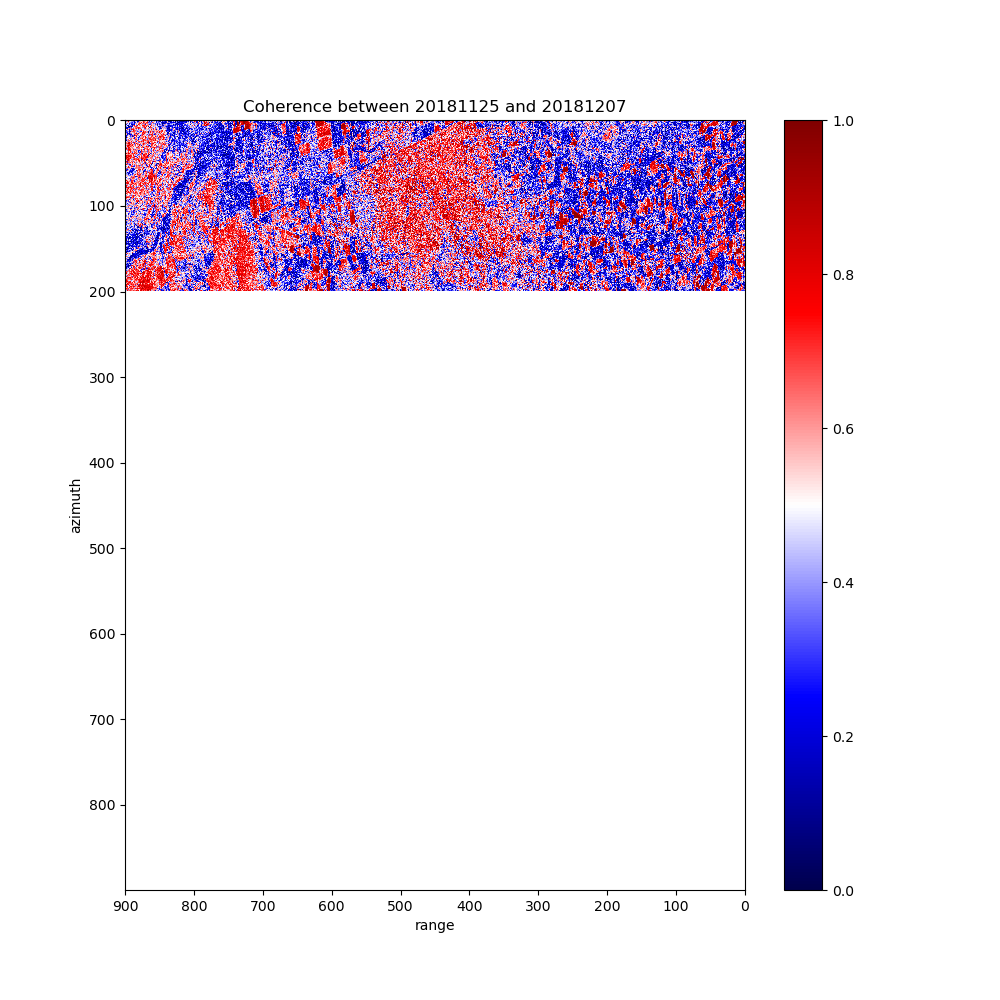

In [11]:
fig = plt.figure(figsize=(10,10))
plt.imshow(cors, vmin=0,vmax=1,cmap='seismic', aspect='auto', \
           interpolation='nearest')
plt.ylabel('azimuth')
plt.xlabel('range')
plt.xlim([900,0])
plt.title('Coherence between '+date1+' and '+date2)
plt.colorbar()
plt.show()

In [12]:
# set up empty arrays
slc1 = np.ndarray([alooks,dx],'complex')
slc2 = np.ndarray([alooks,dx],'complex')
cors = np.ndarray([int(dy/alooks),int(dx/rlooks),nd-1],'float')

for i in np.arange(nd-1): #loop through subsequent SLC pairs
    ds1 = gdal.Open(workdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", gdal.GA_ReadOnly)
    ds2 = gdal.Open(workdir+"SLC_vv/"+dates[i+1]+"/"+dates[i+1]+".slc.full", gdal.GA_ReadOnly)
    for j in range(0,dy-1,alooks): #loop over 4x30000 strips
        slc1[:,:] = ds1.GetRasterBand(1).ReadAsArray(0,j,dx,alooks)
        slc2[:,:] = ds2.GetRasterBand(1).ReadAsArray(0,j,dx,alooks)
        
        a   = slc1*np.conj(slc1)
        b   = slc2*np.conj(slc2)
        c   = slc1*np.conj(slc2)
        ca  = abs(c) 
            
        asum = signal.convolve2d(a, wind2d, mode='same') 
        bsum = signal.convolve2d(b, wind2d, mode='same')
        csum = signal.convolve2d(c, wind2d, mode='same')
        cmag = signal.convolve2d(ca, wind2d, mode='same')
        
        #cpx3 = csum/np.sqrt(asum*bsum) #alternative def of coherence
        cpx3 = csum/cmag
        cpx3 = np.mean(cpx3,axis=0)
        sm   = abs(cpx3)
        sm[np.isnan(sm)] = 0;
        
        if j==5:
            cors[math.floor(j/alooks),:,i] = sm[10::20]
        else:    
            cors[math.ceil(j/alooks),:,i] = sm[10::20]
    
    good        = cors>0
    cors[~good] = np.nan
    print('finished '+str(i+1)+'th igram')

#compute mean, median, and std dev
cor_avg = np.mean(cors,axis=2)
cor_med = np.median(cors,axis=2)
cor_std = np.std(cors,axis=2)

driver=gdal.GetDriverByName('ISCE')
colds = driver.Create(workdir+'cor_avg.r4',dldx,dldy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(cor_avg)
colds=None

colds = driver.Create(workdir+'cor_med.r4',dldx,dldy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(cor_med)
colds=None

colds = driver.Create(workdir+'cor_std.r4',dldx,dldy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(cor_std)
colds=None

finished 1th igram


KeyboardInterrupt: 

In [13]:
# read in coherence stats if not saved in output
f1 = gdal.Open(workdir+'cor_avg.r4', gdal.GA_ReadOnly)
cor_avg = f1.ReadAsArray()
f1 = gdal.Open(workdir+'cor_med.r4', gdal.GA_ReadOnly)
cor_med = f1.ReadAsArray()
f1 = gdal.Open(workdir+'cor_std.r4', gdal.GA_ReadOnly)
cor_std = f1.ReadAsArray()
f1 = None

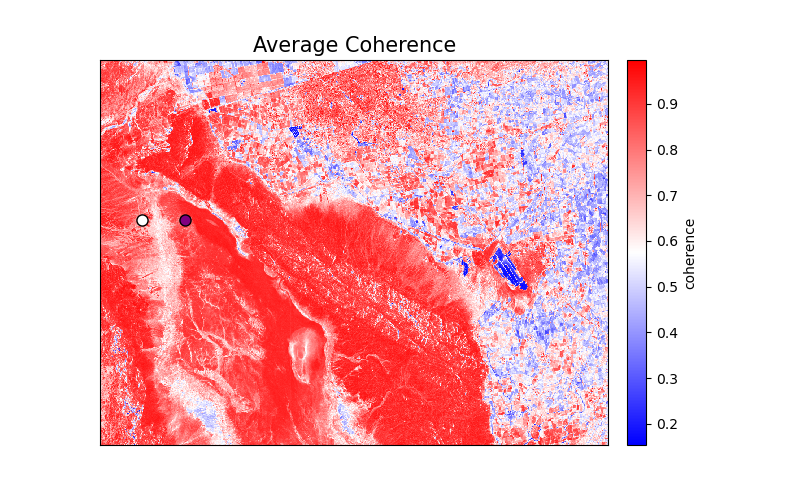

In [14]:
fig = plt.figure(figsize=(8,5))
ax = plt.axes()
im = plt.pcolor(np.flipud(np.fliplr(cor_avg)))
plt.colorbar(orientation='vertical',pad=0.03,label='coherence')
plt.set_cmap('bwr')
ax.ylabel_style = {'size': 15, 'color': 'black'}
ax.xlabel_style = {'size': 15, 'color': 'black'}
plt.title('Average Coherence',fontsize=15)
plt.xticks([]); plt.yticks([])
plt.plot(150,525,'o',color='purple',markersize=8,mec='k')
plt.plot(75,525,'o',color='white',markersize=8,mec='k')
plt.show()

#plt.savefig('coh_avg_AGU.png',transparent=True)

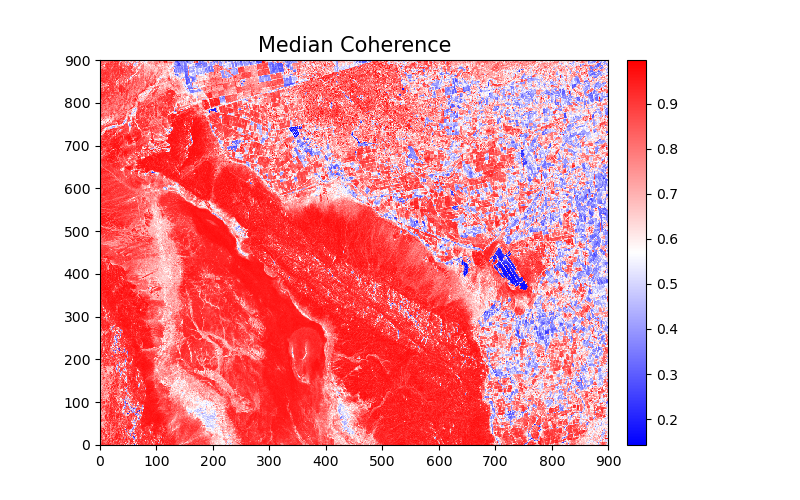

In [15]:
fig = plt.figure(figsize=(8,5))
ax = plt.axes()
im = plt.pcolor(np.flipud(np.fliplr(cor_med)))
plt.colorbar(orientation='vertical',pad=0.03)
plt.set_cmap('bwr')
ax.ylabel_style = {'size': 15, 'color': 'black'}
ax.xlabel_style = {'size': 15, 'color': 'black'}
plt.title('Median Coherence',fontsize=15)
plt.show()

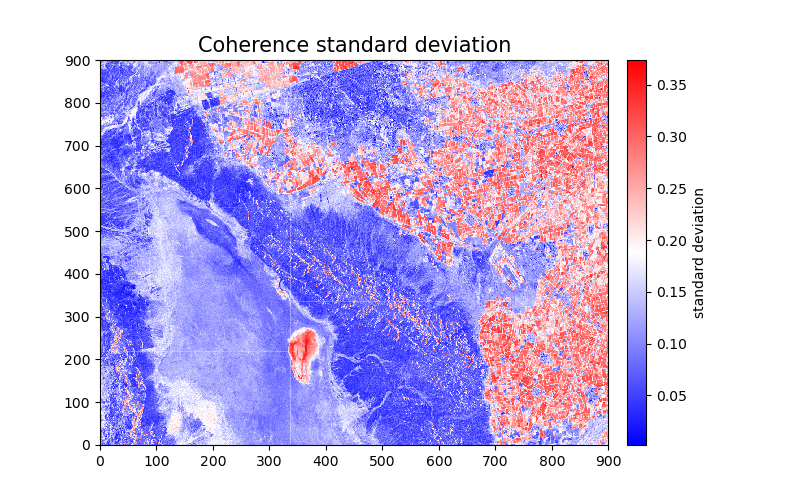

In [16]:
fig = plt.figure(figsize=(8,5))
ax = plt.axes()
im = plt.pcolor(np.flipud(np.fliplr(cor_std)))
plt.colorbar(orientation='vertical',pad=0.03,label='standard deviation')
plt.set_cmap('bwr')
ax.ylabel_style = {'size': 15, 'color': 'black'}
ax.xlabel_style = {'size': 15, 'color': 'black'}
plt.title('Coherence standard deviation',fontsize=15)
#plt.plot(150,525,'o',color='purple',markersize=8,mec='k')
#plt.plot(75,525,'o',color='white',markersize=8,mec='k')
#plt.xticks([]); plt.yticks([])
plt.show()

#plt.savefig('coh_std_AGU.png',transparent=True)

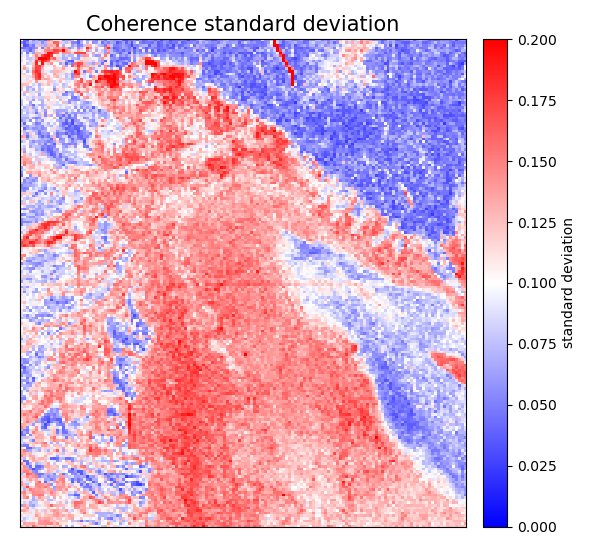

In [17]:
fig = plt.figure(figsize=(6,5.5),tight_layout=True) 
ax = plt.axes()
#im = plt.pcolor(np.flipud(np.fliplr(cor_std)))
im = plt.pcolor(cor_std,vmin=0.0,vmax=0.2)
plt.colorbar(orientation='vertical',pad=0.03,label='standard deviation')
plt.set_cmap('bwr')
ax.ylabel_style = {'size': 15, 'color': 'black'}
ax.xlabel_style = {'size': 15, 'color': 'black'}
plt.title('Coherence standard deviation',fontsize=15)
#plt.plot(150,525,'o',color='purple',markersize=8,mec='k')
#plt.plot(75,525,'o',color='white',markersize=8,mec='k')
plt.xticks([]); plt.yticks([])
plt.xlim([17000/rx,14000/rx]); plt.ylim([1750/ry,1000/ry])
plt.show()

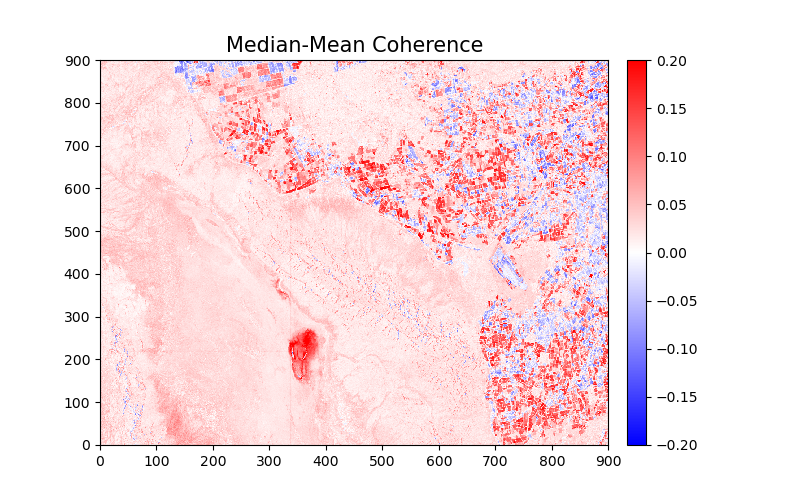

In [18]:
fig = plt.figure(figsize=(8,5))
ax = plt.axes()
im = plt.pcolor(np.flipud(np.fliplr(cor_med-cor_avg)),vmin=-0.2,vmax=0.2)
plt.colorbar(orientation='vertical',pad=0.03)
plt.set_cmap('bwr')
ax.ylabel_style = {'size': 15, 'color': 'black'}
ax.xlabel_style = {'size': 15, 'color': 'black'}
plt.title('Median-Mean Coherence',fontsize=15)
plt.show()